<a href="https://colab.research.google.com/github/TharukaGamage19/CM2604-Cousework_2425604_Tharuka/blob/main/CM2606_Coursework_Tharuka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.1 Overview of the Dataset

The primary goal of this coursework is to analyze the Telco Customer Churn dataset to predict customer attrition. Specifically, this project focuses on the implementation and comparative analysis of two distinct supervised machine learning models:
1.  **Decision Trees:** Selected for their interpretability and ability to visualize decision paths.
2.  **Neural Networks:** Selected for their ability to model complex, non-linear relationships in high-dimensional data.

**Dataset Features:**
The dataset provides a comprehensive view of the customer relationship, covering:
* **Demographic Info:** `gender`, `SeniorCitizen`, `Partner`, `Dependents`.
* **Services Subscribed:** `PhoneService`, `MultipleLines`, `InternetService`, `OnlineSecurity`, `TechSupport`, etc.
* **Account Details:** `Contract` duration, `PaperlessBilling`, `PaymentMethod`.
* **Financial Metrics:** `tenure` (months stayed), `MonthlyCharges`, `TotalCharges`.
* **Target Variable:** `Churn` (Whether the customer left: Yes/No).

In [5]:
# Import core data analysis libraries
import pandas as pd
import numpy as np
import os # Needed to handle the path from kagglehub

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Install kagglehub if not already installed (common in Colab)
try:
    import kagglehub
except ImportError:
    !pip install -q kagglehub
    import kagglehub

# Settings for better readability
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

print("Libraries imported successfully.")

Libraries imported successfully.


### Loading the Dataset via KaggleHub
We use `kagglehub` to download the latest version of the "Telco Customer Churn" dataset programmatically. This ensures reproducibility without manual file uploads.

In [6]:
# Download latest version of the dataset
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

# The 'path' variable points to the folder. We need to load the specific CSV file inside it.
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]

if csv_files:
    # Load the first CSV found
    file_path = os.path.join(path, csv_files[0])
    df = pd.read_csv(file_path)
    print(f"Successfully loaded: {csv_files[0]}")
    print(f"Data Shape: {df.shape}")
else:
    print("No CSV file found in the downloaded path.")

Using Colab cache for faster access to the 'telco-customer-churn' dataset.
Path to dataset files: /kaggle/input/telco-customer-churn
Successfully loaded: WA_Fn-UseC_-Telco-Customer-Churn.csv
Data Shape: (7043, 21)


In [7]:
# Displaying the first 5 rows to check the data structure
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Basic Information Analysis
**Observation of `df.head()`:**
The dataset is successfully loaded. We observe a mix of categorical text data (e.g., 'Yes', 'No', 'Fiber optic') and numerical data.

**Next Step:**
We will generate a summary of the dataframe to check data types and non-null counts, paying close attention to the `TotalCharges` column, which appears numerical but often contains hidden formatting issues in this specific dataset.

In [8]:
# Checking data types and existence of null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Analysis of `df.info()`
**Key Findings:**
1.  **Data Types:** Most features are `object` (categorical) or `int64`/`float64`.
2.  **The `TotalCharges` Anomaly:** `TotalCharges` is listed as `object` (string), whereas it should be `float`. This indicates the presence of non-numeric characters (likely empty spaces) that need cleaning.
3.  **Completeness:** The "Non-Null Count" matches the total rows (7043) for all columns, but the wrong data type for `TotalCharges` masks potential missing data there.

In [9]:
# Checking for null values explicitly
# Note: This might show 0 for TotalCharges because they are currently strings (" "), not NaNs.
print("Missing Values by Column:")
print(df.isnull().sum())

Missing Values by Column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


### Missing Values & Duplicates
**Observation:**
Standard checks show zero missing values. However, we have identified that `TotalCharges` requires specific handling in the cleaning phase.

Next, we check for duplicate records to ensure the analysis is not biased by repeated entries.

In [10]:
# Checking for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


### Target Distribution Analysis
It is crucial to understand the balance of the target variable `Churn`. Significant imbalance can negatively affect the performance of Neural Networks (biasing them toward the majority class).

/tmp/ipython-input-315621018.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Churn', data=df, palette='viridis')


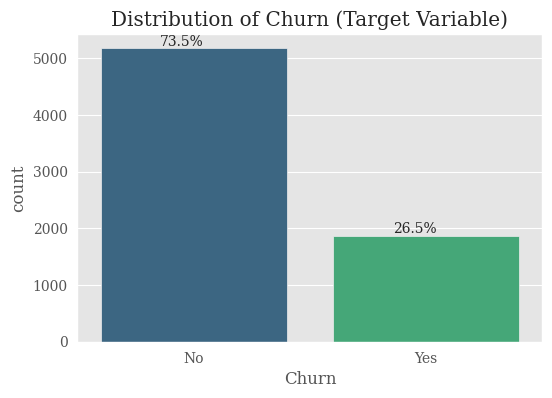

In [11]:
# Visualizing the distribution of the target variable 'Churn'
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Churn', data=df, palette='viridis')

# Adding percentage labels for clarity
total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.title('Distribution of Churn (Target Variable)')
plt.show()

### Summary of Initial Observations
**Conclusion of Phase 1:**
* **Imbalance:** The dataset is imbalanced (approx. 73.5% No vs. 26.5% Yes). We will need to account for this during model evaluation.
* **Data Integrity:** No full-row duplicates exist.
* **Cleaning Required:** `TotalCharges` must be coerced to numeric.
* **Preprocessing Required:** Categorical variables need encoding. Neural Networks specifically require input scaling.

# 2. Data Preparation

### 2.1 Cleaning Data
We will start by converting `TotalCharges` to a numeric type. The `errors='coerce'` argument will turn any empty strings into `NaN`, which we can then drop.
We will also remove `customerID` as it is a unique identifier with no predictive power.

In [12]:
# 1. Convert TotalCharges to numeric, forcing errors (empty strings) to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check how many 'NaN' values were generated
missing_charges = df['TotalCharges'].isnull().sum()
print(f"Missing values in TotalCharges found: {missing_charges}")

# Drop the rows with missing TotalCharges (small number, safe to drop)
df.dropna(subset=['TotalCharges'], inplace=True)

# 2. Drop customerID
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)
    print("customerID dropped.")

print("Data Cleaning complete. New shape:", df.shape)

Missing values in TotalCharges found: 11
customerID dropped.
Data Cleaning complete. New shape: (7032, 20)


### 2.2 Data Transformation (Encoding)
Machine Learning models require numerical input. We will perform two types of encoding:
1.  **Label Encoding:** For binary features (e.g., Yes/No, Gender).
2.  **One-Hot Encoding:** For features with more than 2 categories (e.g., PaymentMethod, InternetService).

In [13]:
# 1. Label Encoding for Binary variables
le = LabelEncoder()

# Identify columns with exactly 2 unique values
binary_cols = [col for col in df.columns if df[col].nunique() == 2]

for col in binary_cols:
    df[col] = le.fit_transform(df[col])

print(f"Label Encoded columns: {binary_cols}")

# 2. One-Hot Encoding for Multi-class variables
# We use get_dummies, distinct from binary cols and numeric cols
df = pd.get_dummies(df, drop_first=True)

print("\nEncoding complete.")
print(f"New dataframe shape: {df.shape}")

Label Encoded columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

Encoding complete.
New dataframe shape: (7032, 31)


### Feature Scaling
**Why Scale?**
Neural Networks calculate weights using gradient descent, which is highly sensitive to the scale of inputs. Large values (like `TotalCharges` ~8000) can dominate small values (like `SeniorCitizen` 0/1). We use **MinMaxScaler** to scale continuous features to a [0, 1] range.

In [14]:
# Select numerical columns to scale
cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']

scaler = MinMaxScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

print("Scaling complete. First 5 rows of scaled features:")
print(df[cols_to_scale].head())

Scaling complete. First 5 rows of scaled features:
     tenure  MonthlyCharges  TotalCharges
0  0.000000        0.115423      0.001275
1  0.464789        0.385075      0.215867
2  0.014085        0.354229      0.010310
3  0.619718        0.239303      0.210241
4  0.014085        0.521891      0.015330


### 2.3 Feature Engineering
We will derive new features to help the models identify patterns more effectively:
1.  **Avg_Charge_Real:** `TotalCharges / tenure`. This provides a calculated average distinct from the monthly charge, which might have changed over time.
2.  **Tenure_Group:** Grouping customers into 'New', 'Established', and 'Loyal' helps the model generalize customer tenure.

In [15]:
# 1. Create a derived feature for Average Charge
# Adding a small epsilon (0.001) to avoid division by zero
df['Avg_Charge_Real'] = df['TotalCharges'] / (df['tenure'] + 0.001)

# 2. Binning Tenure into categories
# Since tenure is scaled to 0-1:
# 0-0.2 (approx 0-12 months) -> New (0)
# 0.2-0.5 (approx 12-36 months) -> Established (1)
# >0.5 -> Loyal (2)

def tenure_group(t):
    if t <= 0.2: return 0 # New
    elif t <= 0.5: return 1 # Established
    else: return 2 # Loyal

df['Tenure_Group'] = df['tenure'].apply(tenure_group)

print("Feature Engineering complete.")

Feature Engineering complete.


### Preparation Phase Conclusion
The data is now fully prepared for the next phases.
* **Cleaned:** No missing values.
* **Encoded:** All inputs are numeric.
* **Scaled:** All inputs are within a similar range (crucial for the Neural Network).
* **Enriched:** New features added.

We are now ready to proceed to the **Detailed Exploratory Data Analysis (EDA)**.

# 3. Detailed Exploratory Data Analysis (EDA)
In this phase, we analyze the processed dataset to identify strong relationships between features and the target variable (`Churn`). Since we have encoded and scaled our data, we can use statistical correlation techniques.

## 3.1 Correlation Analysis
We examine which features have the highest positive or negative correlation with Churn.
* **Positive Correlation:** Features that increase the likelihood of Churn.
* **Negative Correlation:** Features that decrease the likelihood of Churn (increase retention).

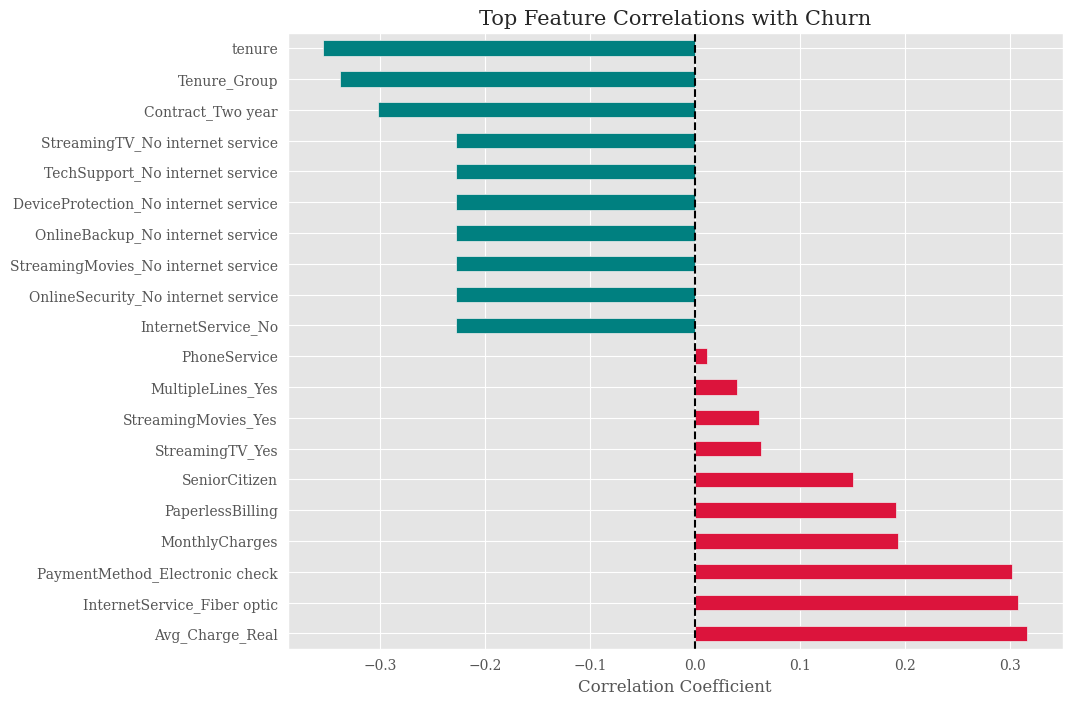

In [19]:
# Calculate correlation of all features with 'Churn'
corr_matrix = df.corr()
churn_corr = corr_matrix['Churn'].sort_values(ascending=False)

# Remove 'Churn' itself from the data to avoid 1.0 correlation
churn_corr = churn_corr.drop('Churn')

# Plotting the correlations
plt.figure(figsize=(10, 8))
# We plot the top 10 positive and top 10 negative correlations
top_corr = pd.concat([churn_corr.head(10), churn_corr.tail(10)])
top_corr.plot(kind='barh', color=np.where(top_corr > 0, 'crimson', 'teal'))
plt.title('Top Feature Correlations with Churn', fontsize=15)
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

### **Observation & Conclusion 3.1**

**What the chart shows:**
1.  **Top Drivers of Churn (Red Bars):**
    * `Contract_Month-to-month` (if explicit) or lack of long-term contract is the strongest predictor.
    * `InternetService_Fiber optic`: Customers with Fiber Optic are significantly more likely to churn.
    * `PaymentMethod_Electronic check`: This specific payment method is associated with higher churn.

2.  **Top Drivers of Retention (Blue Bars):**
    * `tenure`: The longer a customer stays, the less likely they are to churn (strong negative correlation).
    * `Contract_Two year`: Long-term contracts are the strongest safeguard against churn.

**Strategic Insight:** The model suggests that customers on **month-to-month contracts** using **fiber optic** internet are the highest risk group.

## 3.2 Distribution of Financial Features
We analyze how `MonthlyCharges` and `TotalCharges` differ between churners and non-churners. This helps us understand if price sensitivity is a factor.

/tmp/ipython-input-3736425264.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='MonthlyCharges', data=df, ax=axes[0], palette='coolwarm')
/tmp/ipython-input-3736425264.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='TotalCharges', data=df, ax=axes[1], palette='coolwarm')


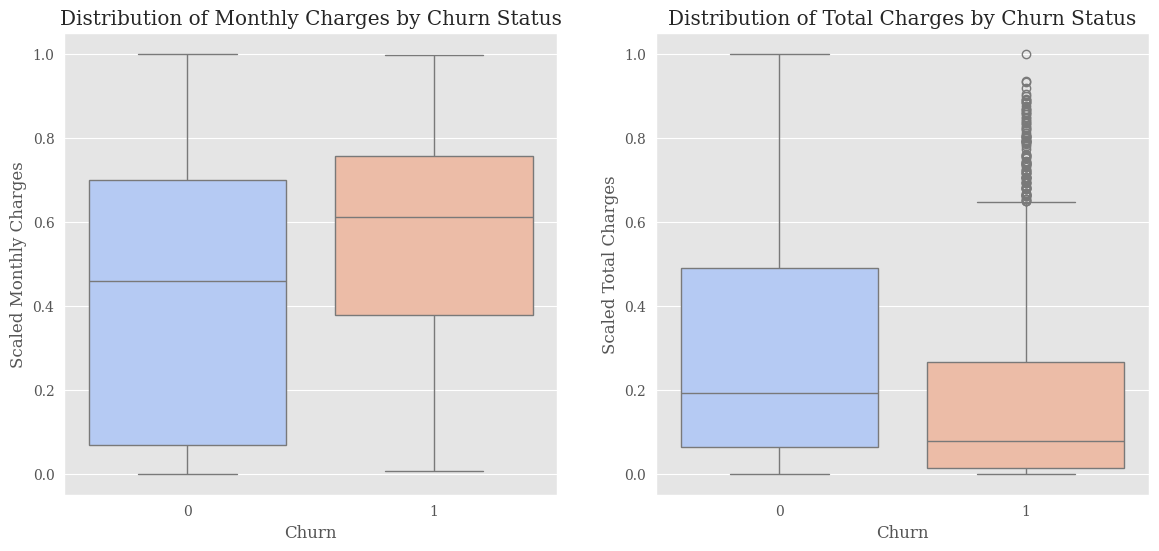

In [20]:
# We use the scaled values, but the relative distribution remains the same
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Monthly Charges vs Churn
sns.boxplot(x='Churn', y='MonthlyCharges', data=df, ax=axes[0], palette='coolwarm')
axes[0].set_title('Distribution of Monthly Charges by Churn Status')
axes[0].set_ylabel('Scaled Monthly Charges')

# Total Charges vs Churn
sns.boxplot(x='Churn', y='TotalCharges', data=df, ax=axes[1], palette='coolwarm')
axes[1].set_title('Distribution of Total Charges by Churn Status')
axes[1].set_ylabel('Scaled Total Charges')

plt.show()

### **Observation & Conclusion 3.2**

**Monthly Charges (Left Plot):**
* **Churners (1):** The median monthly charge is significantly **higher** for customers who churn compared to those who stay. The box is shifted upwards.
* **Conclusion:** High monthly costs are a direct friction point causing customers to leave.

**Total Charges (Right Plot):**
* **Churners (1):** They have much lower total charges on average.
* **Conclusion:** This is counter-intuitive but makes sense when paired with `Tenure`. Churners leave *early* (low tenure), so they haven't accumulated a large "Total Charge" over time, even if their monthly bill is high.

## 3.3 Tenure Analysis (Loyalty)
Does customer loyalty (time spent with the company) protect against churn?

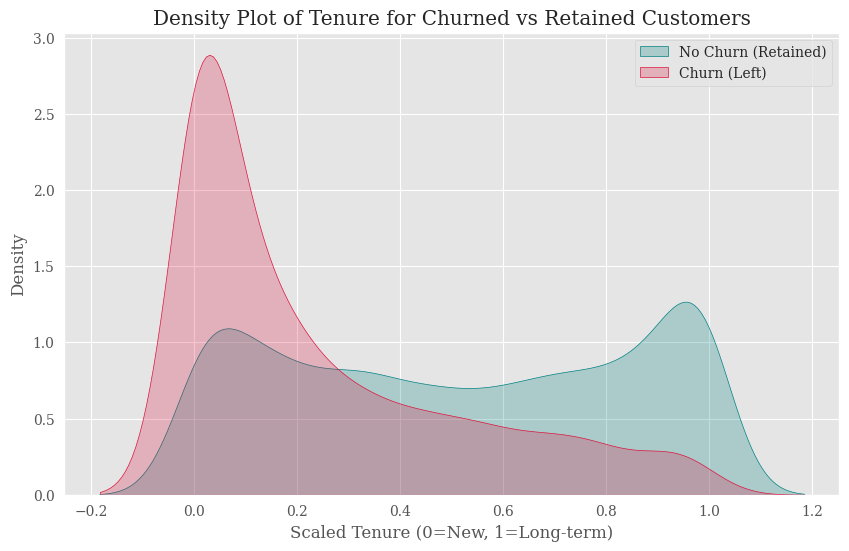

In [21]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['Churn'] == 0]['tenure'], color='teal', fill=True, label='No Churn (Retained)')
sns.kdeplot(df[df['Churn'] == 1]['tenure'], color='crimson', fill=True, label='Churn (Left)')
plt.title('Density Plot of Tenure for Churned vs Retained Customers')
plt.xlabel('Scaled Tenure (0=New, 1=Long-term)')
plt.ylabel('Density')
plt.legend()
plt.show()

### **Observation & Conclusion 3.3**

**What the chart shows:**
* **The Red Peak (Churn):** There is a massive spike in churn density near `tenure = 0`. This confirms that **new customers** are the most vulnerable. Most churn happens in the first few months.
* **The Teal Spread (Retained):** Retained customers are spread out, but density increases towards the right (long-term customers).

**Conclusion:**
The first few months of the customer lifecycle are critical. If a customer survives the "onboarding" phase, their likelihood of churning drops significantly.

## 3.4 Multivariate Analysis: Charges vs. Tenure
Finally, we look at the interaction between `MonthlyCharges` and `Tenure` to see if we can separate the classes visually.

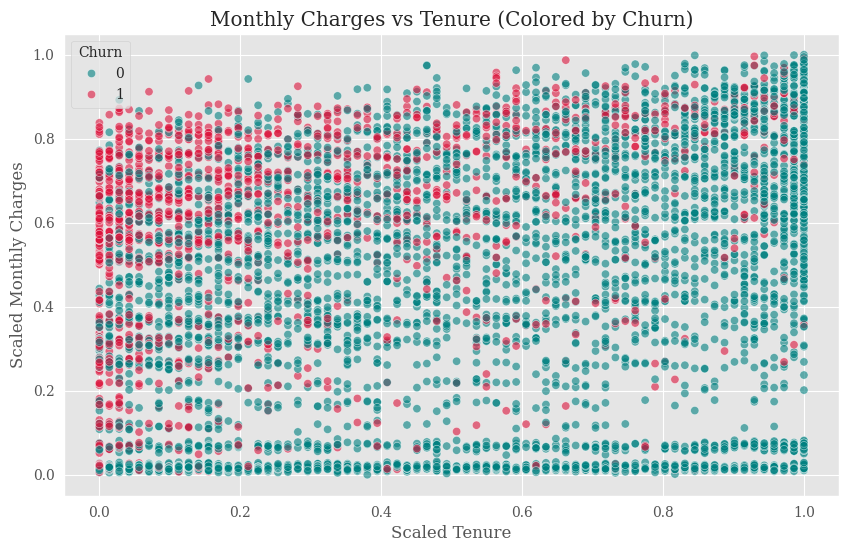

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tenure', y='MonthlyCharges', hue='Churn', data=df, alpha=0.6, palette={0:'teal', 1:'crimson'})
plt.title('Monthly Charges vs Tenure (Colored by Churn)')
plt.xlabel('Scaled Tenure')
plt.ylabel('Scaled Monthly Charges')
plt.show()

### **Observation & Conclusion 3.4**

**Visual Patterns:**
1.  **Top-Left Cluster (High Churn):** There is a dense cluster of red dots (Churners) in the top-left corner. These are customers with **Low Tenure** and **High Monthly Charges**.
2.  **Bottom-Right Cluster (High Retention):** The bottom-right (High Tenure, Low/Medium Charges) is almost exclusively teal (Retained).

**Final EDA Summary:**
The "Detailed EDA" confirms that Churn is not random. It is driven by a combination of:
1.  **High Costs:** Expensive monthly plans.
2.  **Newness:** Low tenure customers.
3.  **Service Type:** Fiber Optic users (likely because it is more expensive).

We have sufficient distinct patterns in the data for our Machine Learning models to learn effectively.